- Факторы которые влияют на энергопотребление? - почему?
- найти факторы и сделать рейтинг факторов
- Один дом, один файл.
- PDF и код юпитера
- К репозиторию файл README


### Инициализация и загрузка данных

In [1]:
import os
import pandas as pd
import re
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Для отладки
set_debug = True

# Небольшой код который сам ищет необходимые файлы на компьютере
# Достаточно установить пути где данные файлы могут находится
# Файлы которые нужно искать
# Ипапка в которых располагается статистика 

# Пути к файлам данных

# smart_meters_folder_path1 = 'Y:/temp/AnacondaProjects/smart-meters-in-london'
smart_meters_folder_path1 = 'Z:/temp/AnacondaProjects/smart-meters-in-london'

daily_dataset_file = '{}/daily_dataset.csv/daily_dataset.csv'.format(smart_meters_folder_path1)
informations_households_file = '{}/informations_households.csv'.format(smart_meters_folder_path1)
weather_hourly_darksky_file = '{}/weather_hourly_darksky.csv'.format(smart_meters_folder_path1)

halfhourly_dataset_folder = 'C:/Users/konst/Desktop/halfhourly_dataset'
# halfhourly_dataset_folder = 'C:/Users/konst/AnacondaProjects/smart-meters-in-london/halfhourly_dataset'


# Для переключения режима отладки, выводит если set_debug == True
def debug(*args, **kwargs):
    if set_debug is True:
        print(*args, **kwargs)

# Функция загружает файлы, на вход подается список файлов и директория, на выходе склеенный датафрейм
# пример: df_informations_households = load_files(['^informations_households.csv$'], smart_meters_folder_path1)
def load_files(l_files, directory, names=None):
    data = pd.DataFrame()
    for root, dirs, files in os.walk(directory):
        for l_file in l_files:
            for file in files:
                if re.search(l_file, file):
                    temp = pd.read_csv(os.path.join(root, file), encoding='ANSI', names = names)
                    data = pd.concat([data, temp])
                    debug(len(data))
                    debug(file, l_file, os.path.join(root, file))
    return data

In [2]:
# Загрузка файлов в Pandas
#df_acorn_details = load_files(['^acorn_details.csv$'], smart_meters_folder_path1)
#df_uk_bank_holidays = load_files(['^uk_bank_holidays.csv$'], smart_meters_folder_path1)
#df_weather_daily_darksky = load_files(['^weather_daily_darksky.csv$'], smart_meters_folder_path1)
#df_weather_hourly_darksky = load_files(['^weather_hourly_darksky.csv$'], smart_meters_folder_path1)

# Информация о датчиках энергопотребления и краткие сведения о домах, в которых эти датчики установлены. Столбцы датафреима:
# LCLid – id датчика;
# stdorToU – форма оплаты за электроэнергию в доме, в котором установлен датчик (Std –
# стандартная, ToU – оплата зависит от времени суток);
# Acorn, Acorn_grouped – информация о том, к какой категории потребителей по системе ACORN относится семья, проживающая в данном доме;
# file – имя фаила, содержащего показатели счетчиков.
df_informations_households = pd.read_csv(informations_households_file)

# Архив содержит 112 фаилов, содержащих обобщенные данные об энергопотреблении за каждые сутки.
# Каждый фаил содержит информацию с датчиков, установленных в одном доме. Столбцы датафреима:
# LCLid – id датчика;
# day – дата;
# energy_median – медиана суточных показателей;
# energy_mean – среднее арифметическое суточных показателей;
# energy_max – максимальное значение энергопотребления, зафиксированное датчиком в течение дня;
# energy_count – количество показателей, зафиксированных датчиком в течение дня;
# energy_std – стандартное отклонение;
# energy_sum – сумма значений всех показателей;
# energy_min – минимальное значение энергопотребления, зафиксированное датчиком в течение дня.
# df_daily_dataset = load_files(['^daily_dataset.csv$'], smart_meters_folder_path1)
df_daily_dataset = pd.read_csv(daily_dataset_file,  parse_dates = ['day'])

### Информация о загруженных данных

In [3]:
df_informations_households.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5566 entries, 0 to 5565
Data columns (total 5 columns):
LCLid            5566 non-null object
stdorToU         5566 non-null object
Acorn            5566 non-null object
Acorn_grouped    5566 non-null object
file             5566 non-null object
dtypes: object(5)
memory usage: 217.5+ KB


In [4]:
df_daily_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3510433 entries, 0 to 3510432
Data columns (total 9 columns):
LCLid            object
day              datetime64[ns]
energy_median    float64
energy_mean      float64
energy_max       float64
energy_count     int64
energy_std       float64
energy_sum       float64
energy_min       float64
dtypes: datetime64[ns](1), float64(6), int64(1), object(1)
memory usage: 241.0+ MB


### Определение типа счетчика в зависимости от класса ACORN
Получение процентного соотношения ToU/Std в зависимости от класса

In [5]:
# выдает 1 если счетчик ToU
def count_ToU(row):
    if row['stdorToU'] == 'ToU':
        return 1
    return 0

# выдает 1 если счетчик Std
def count_Std(row):
    if row['stdorToU'] == 'Std':
        return 1
    return 0

def ToU_percentage(row):
    return round((row['ToU'] / (row['ToU'] + row['Std']))*100,1)

In [6]:
df_informations_households.head()

,LCLid,stdorToU,Acorn,Acorn_grouped,file
0,MAC005492,ToU,ACORN-,ACORN-,block_0
1,MAC001074,ToU,ACORN-,ACORN-,block_0
2,MAC000002,Std,ACORN-A,Affluent,block_0
3,MAC003613,Std,ACORN-A,Affluent,block_0
4,MAC003597,Std,ACORN-A,Affluent,block_0


In [7]:
# Изменяем таблицу df_informations_households так, чтобы тип счетчика был в раздельных столбцах ToU Std
# Обогащение нужными нам данными
df_informations_households['ToU'] = df_informations_households.apply(count_ToU, axis=1)
df_informations_households['Std'] = df_informations_households.apply(count_Std, axis=1)
df_informations_households.head(1)

,LCLid,stdorToU,Acorn,Acorn_grouped,file,ToU,Std
0,MAC005492,ToU,ACORN-,ACORN-,block_0,1,0


In [8]:
# Группируем с нахождением кол-ва типов счетчиков для каждого класса
counter_type_stats = df_informations_households.groupby(by = 'Acorn', as_index=False)['ToU', 'Std'].sum()

# Вычесляем процент установленных счетчиков ToU
counter_type_stats['ToU_perc'] = counter_type_stats.apply(ToU_percentage, axis=1)

### Процент счетчиков ToU в зависимости от класса

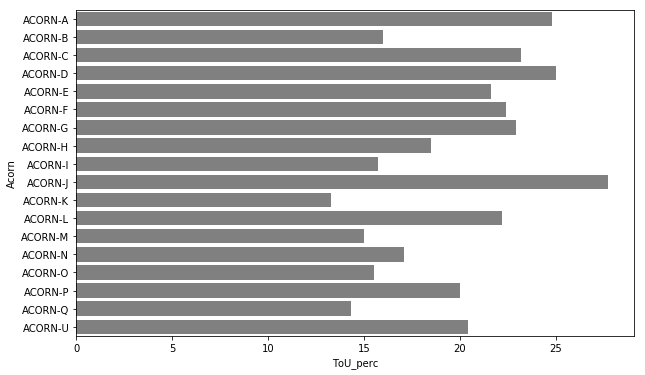

In [9]:
# Строим график
plt.figure(figsize=(10, 6))
sns.barplot(x = 'ToU_perc', y = 'Acorn', color='gray', data = counter_type_stats[counter_type_stats['Acorn'] != 'ACORN-'])

### Расчет среднего потребления энергии в зависимости от класса

In [10]:
# обогащение данных
daily_dataset_with_hh_info = df_daily_dataset.merge(df_informations_households, how = 'left', on = 'LCLid')

In [11]:
# Просмотр минимальных и максимальных дат по каждому классу для того чтобы определить насколько полные данные нам предоставлены
daily_dataset_with_hh_info[ daily_dataset_with_hh_info['energy_count'] == 48][['Acorn', 'day']]\
.groupby(by = 'Acorn')['day'].agg([min, max])

,min,max
Acorn,,
ACORN-,2012-04-18,2014-02-27
ACORN-A,2011-12-04,2014-02-27
ACORN-B,2011-12-24,2014-02-27
ACORN-C,2011-12-07,2014-02-27
ACORN-D,2011-11-24,2014-02-27
ACORN-E,2011-11-24,2014-02-27
ACORN-F,2011-11-24,2014-02-27
ACORN-G,2011-11-24,2014-02-27
ACORN-H,2011-11-25,2014-02-27


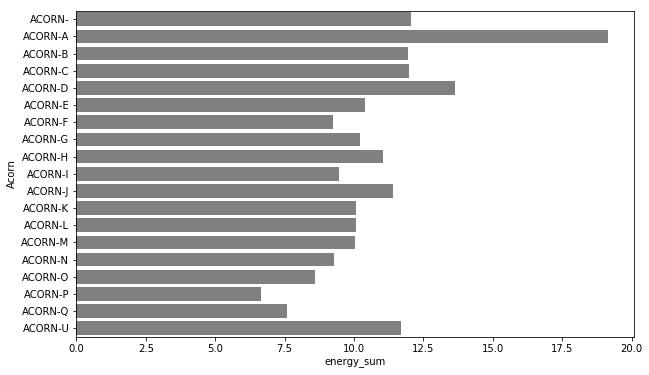

In [12]:
# График среднего энегропотребления в зависимости от класса
plt.figure(figsize=(10, 6))
sns.barplot(
    x = 'energy_sum',
    y = 'Acorn',
    color='gray',
    data = daily_dataset_with_hh_info[ daily_dataset_with_hh_info['energy_count'] == 48]\
    .groupby(by = 'Acorn', as_index=False).agg({'energy_sum':np.mean})
)

In [13]:
# Просмотр кол-ва счетчиков в каждом классе, для оценки предоставленных данных 
daily_dataset_with_hh_info[ daily_dataset_with_hh_info['energy_count'] == 48][['Acorn', 'day']]\
.groupby(by = 'Acorn', as_index=False)['day'].count()

,Acorn,day
0,ACORN-,771
1,ACORN-A,91872
2,ACORN-B,14321
3,ACORN-C,87783
4,ACORN-D,186880
5,ACORN-E,1011407
6,ACORN-F,441804
7,ACORN-G,122381
8,ACORN-H,268989
9,ACORN-I,29120


C:\Users\konst\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



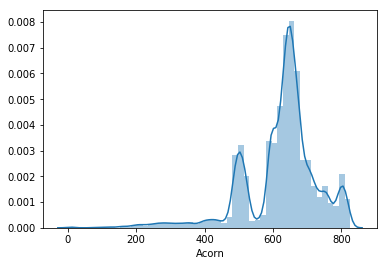

In [14]:
# Смотрим разпределение кол-ва показаний для счетчиков, чтоб понимать, насколько полные данные у нас имеются
df = daily_dataset_with_hh_info[ daily_dataset_with_hh_info['energy_count'] == 48][['LCLid', 'Acorn', 'day']]\
.groupby(by = 'LCLid', as_index=False)['day', 'Acorn'].count()
sns.distplot(df['Acorn'])

# освобождаем память
df = None

#### Расчет результата и строительство графика по классам

In [15]:
# создаем датафрейм, в котором для каждой категории ACORN показан средний расход по разным типам счетчиков
# Исключаем дни с неполными показаниями, менее 48 и неопределенную категорию
counter_type_consumption = daily_dataset_with_hh_info[
    (daily_dataset_with_hh_info['energy_count'] == 48) &
    (daily_dataset_with_hh_info['Acorn'] != 'ACORN-')
].groupby(by = ['Acorn', 'stdorToU'], as_index=False)['energy_sum', 'energy_max'].mean()

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17],
 <a list of 18 Text xticklabel objects>)

<Figure size 720x720 with 0 Axes>

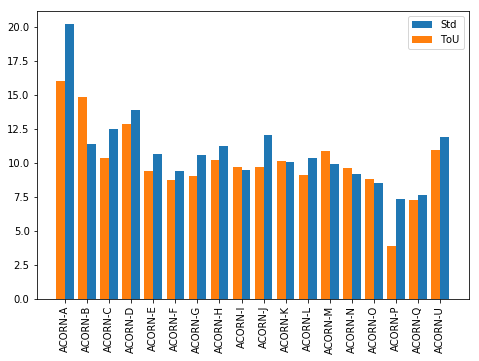

In [16]:
# Строим график для наглядности данных

# Трансформируем таблицу чтобы средние показания счетчиков были разненсены по колонкам
ct = counter_type_consumption.pivot(
    index='Acorn', columns='stdorToU', values='energy_sum'
).reset_index()

# Строим график

# Размер
plt.figure(figsize=(10, 10))
fig = plt.figure()
axes = fig.add_axes([0, 0, 1, 1])
axes.bar(x = ct['Acorn'], height = ct['Std'], 
         width = 0.4, align = 'edge', label = 'Std')
axes.bar(x = ct['Acorn'], height = ct['ToU'], 
         width = -0.4, align = 'edge', label = 'ToU')
axes.legend(loc = 1)

# Поворот подписей по оси Х
plt.xticks(rotation=90)

#### Расчет общего влияния установки счетчика:

In [17]:
# создаем датафрейм, в котором для каждого типа счетчика показан средний расход
# Исключаем дни с неполными показаниями, менее 48 и неопределенную категорию
report = daily_dataset_with_hh_info[
    (daily_dataset_with_hh_info['energy_count'] == 48) &
    (daily_dataset_with_hh_info['Acorn'] != 'ACORN-')
].groupby(by = 'stdorToU', as_index=False).mean()

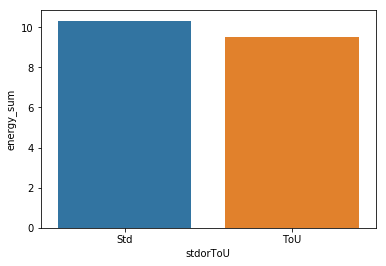

In [18]:
# строим график
sns.barplot(x = 'stdorToU', y = 'energy_sum', data = report)

#### Вычисляем общий процент экономии:

In [19]:
def ToU_percentage(row):
    return round((row['ToU']/((row['Std'] + row['ToU'])/2))*100)-100

def Std_percentage(row):
    return round((row['Std']/((row['Std'] + row['ToU'])/2))*100)-100

# создаем датафрейм, в котором для каждого типа счетчика показан средний расход
# Исключаем дни с неполными показаниями, менее 48 и неопределенную категорию
report = daily_dataset_with_hh_info[
    (daily_dataset_with_hh_info['energy_count'] == 48) &
    (daily_dataset_with_hh_info['Acorn'] != 'ACORN-')
].groupby(by = 'stdorToU')['energy_sum'].mean()

# Делаем из серийного объекта датафрейм и поворачиваем его для удобства
report2 = pd.DataFrame(index = report.index, data={'avg_power':report.values}).T
report2['Std_p'] = report2.apply(Std_percentage, axis=1)
report2['ToU_p'] = report2.apply(ToU_percentage, axis=1)

#### Расчет показывает экономию 4% от среднего значения дневного потребления энегрии по всем классам и всем счетчикам
#### Потребление домохозяйств с установленными счетчиками ToU снижено на 8% по сравнению со стандартным Std

In [20]:
report2[['Std_p', 'ToU_p']]

stdorToU,Std_p,ToU_p
avg_power,4.0,-4.0


In [21]:
report

stdorToU
Std    10.323564
ToU     9.531409
Name: energy_sum, dtype: float64

### Расчет влияния погоды на потребление энергии

In [22]:
# Загрузка данных о погоде
weather = pd.read_csv(weather_hourly_darksky_file, usecols = ["time", "apparentTemperature"],  parse_dates = ['time'])

# добавление колонки в датасек с округлением до дня
weather['day'] = weather['time'].dt.round("d")

#
weather_min = weather.groupby('day').agg({'apparentTemperature':np.mean})
#weather_min['day'] = weather_min.apply(lambda row: row.loc('time'), axis=1)
weather_min.head()

,apparentTemperature
day,
2011-11-01,13.361667
2011-11-02,11.096800
2011-11-03,14.995217
2011-11-04,14.229600
2011-11-05,12.386522


In [23]:
weather.head()

,time,apparentTemperature,day
0,2011-11-11 00:00:00,10.24,2011-11-11
1,2011-11-11 01:00:00,8.24,2011-11-11
2,2011-11-11 02:00:00,7.76,2011-11-11
3,2011-11-11 03:00:00,7.44,2011-11-11
4,2011-11-11 04:00:00,7.24,2011-11-11


In [24]:
df_daily_dataset.head()

,LCLid,day,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min
0,MAC000131,2011-12-15,0.4850,0.432045,0.868,22,0.239146,9.505,0.072
1,MAC000131,2011-12-16,0.1415,0.296167,1.116,48,0.281471,14.216,0.031
2,MAC000131,2011-12-17,0.1015,0.189812,0.685,48,0.188405,9.111,0.064
3,MAC000131,2011-12-18,0.1140,0.218979,0.676,48,0.202919,10.511,0.065
4,MAC000131,2011-12-19,0.1910,0.325979,0.788,48,0.259205,15.647,0.066


In [25]:
daily_dataset_for_weather = df_daily_dataset[
    (daily_dataset_with_hh_info['energy_count'] == 48) &
    (daily_dataset_with_hh_info['Acorn'] != 'ACORN-')
].groupby('day').agg({'energy_sum':np.mean})
weather_mean = weather.groupby('day').agg({'apparentTemperature':np.mean})

In [26]:
daily_dataset_for_weather.head()

,energy_sum
day,
2011-11-24,10.728615
2011-11-25,10.182200
2011-11-26,10.610687
2011-11-27,10.850805
2011-11-28,10.105561


In [27]:
en_weather = daily_dataset_for_weather.merge(weather_mean, how = 'left', on = 'day')

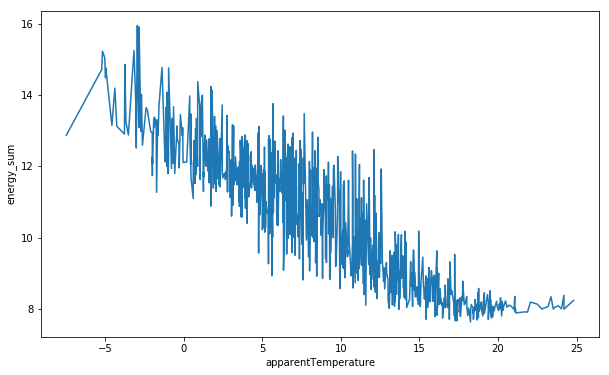

In [28]:
plt.figure(figsize=(10, 6))
sns.lineplot(x="apparentTemperature", y="energy_sum", data=en_weather)

### Расчет влияния на потребление времени суток

In [29]:
# Загрузка данных из файла в словарь hh_inf_dict
hh_inf_dict = {}
with open(informations_households_file, 'r') as f:
    next(f)
    for line in f:
        line = line.strip().split(',')
        hh_inf_dict.setdefault(line[0], {})
        hh_inf_dict[line[0]]['acorn']=line[2]
        hh_inf_dict[line[0]]['type']=line[1]
# hh_inf_dict

In [30]:
# Загрузка всей файлов в папке halfhourly_dataset с получасовыми данными в компактный словарь для рисования графиков
hfhr_ds_dict={}
for root, dirs, files in os.walk(halfhourly_dataset_folder):
    for file in files:
        print(file)
        with open(os.path.join(root, file), 'r') as f:
            next(f)
            for line in f:
                line = line.strip().split(',')
                acorn = hh_inf_dict[line[0]]['acorn']
                c_type = hh_inf_dict[line[0]]['type']
                time_int = str(line[1][11:16])
                if line[2] != 'Null':
                    pwr = float(line[2])
                hfhr_ds_dict.setdefault(acorn, {})
                hfhr_ds_dict[acorn].setdefault(time_int, {})
                hfhr_ds_dict[acorn][time_int].setdefault(c_type, {})
                hfhr_ds_dict[acorn][time_int][c_type].setdefault('value', 0)
                hfhr_ds_dict[acorn][time_int][c_type].setdefault('count', 0)
                hfhr_ds_dict[acorn][time_int][c_type]['value']=hfhr_ds_dict[acorn][time_int][c_type]['value']+pwr
                hfhr_ds_dict[acorn][time_int][c_type]['count']+=1

block_0.csv
block_1.csv
block_10.csv
block_100.csv
block_101.csv
block_102.csv
block_103.csv
block_104.csv
block_105.csv
block_106.csv
block_107.csv
block_108.csv
block_109.csv
block_11.csv
block_110.csv
block_111.csv
block_12.csv
block_13.csv
block_14.csv
block_15.csv
block_16.csv
block_17.csv
block_18.csv
block_19.csv
block_2.csv
block_20.csv
block_21.csv
block_22.csv
block_23.csv
block_24.csv
block_25.csv
block_26.csv
block_27.csv
block_28.csv
block_29.csv
block_3.csv
block_30.csv
block_31.csv
block_32.csv
block_33.csv
block_34.csv
block_35.csv
block_36.csv
block_37.csv
block_38.csv
block_39.csv
block_4.csv
block_40.csv
block_41.csv
block_42.csv
block_43.csv
block_44.csv
block_45.csv
block_46.csv
block_47.csv
block_48.csv
block_49.csv
block_5.csv
block_50.csv
block_51.csv
block_52.csv
block_53.csv
block_54.csv
block_55.csv
block_56.csv
block_57.csv
block_58.csv
block_59.csv
block_6.csv
block_60.csv
block_61.csv
block_62.csv
block_63.csv
block_64.csv
block_65.csv
block_66.csv
block_6

In [31]:
# Функция которая преобразует строку вида HH:MM в интервал от 0 до 23.5
# например 1 это 1 час; 12.5 это 12часов 30минут
def time_to_day_interval(string):
    i = 0
    for h in ['00','01','02','03','04','05',
              '06','07','08','09','10','11',
              '12','13','14','15','16','17',
              '18','19','20','21','22','23']:
        for m in ['00','30']:
            if '{}:{}'.format(h,m) in string:
                return i
            i=i+0.5

# создание нового датафрейма
time_stats = pd.DataFrame([], columns=['acorn', 'interval', 'pwr_c'])

# Цикл добавляет в датафрейм time_stats данные из массива hfhr_ds_dict
for key in hfhr_ds_dict.keys():
    for it in hfhr_ds_dict[key]:
#        print(hfhr_ds_dict[key][it])
        t_interv = time_to_day_interval(it)
        for ct in hfhr_ds_dict[key][it]:
            if t_interv is not None:
                time_stats = time_stats.append({'acorn': key, 'interval': t_interv, 'ct': ct, 'pwr_c': hfhr_ds_dict[key][it][ct]['value']/hfhr_ds_dict[key][it][ct]['count']}, ignore_index=True)

# Добавление в датафрейм time_stats данных о среднем энергопотреблении, для этого
# создаем псевдо-группу ACORN-MED
for index, row in time_stats.groupby('interval', as_index=False).agg({'pwr_c':np.mean}).iterrows():
    time_stats = time_stats.append({'acorn': 'ACORN-MED', 'interval': row[0], 'pwr_c': row[1]}, ignore_index=True)

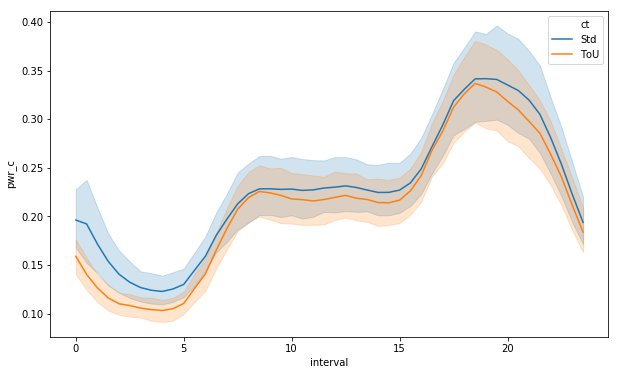

In [32]:
# График потребления в зависимости от времени для всех классов c подсветкой по типам счетчиков
plt.figure(figsize=(10, 6))
sns.lineplot(x="interval", y="pwr_c", data=time_stats, hue='ct')

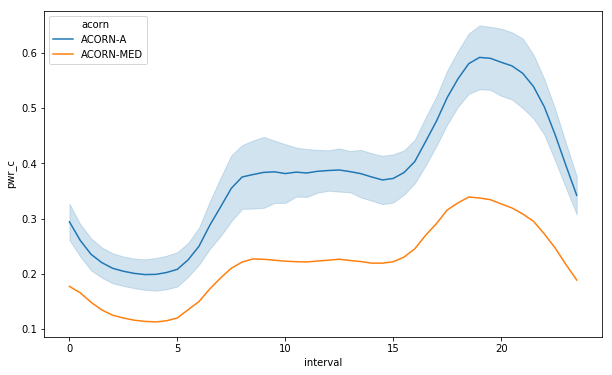

In [33]:
# Рисуем график сравнения потребления конкретного класса со средним значением
plt.figure(figsize=(10, 6))
sns.lineplot(x="interval", y="pwr_c", data=time_stats[(time_stats['acorn']=='ACORN-A') |
                                                      (time_stats['acorn']=='ACORN-MED')],
             hue = 'acorn')